# Utils

### Imports

In [27]:
import random
from typing import List
from gxgp.node import Node
from utils.operations_dict import basic_function_set, complex_function_set

# If updates on imported files aren't detected, restart the kernel (we'll need to find an automatic solution for this)

import numpy as np
from icecream import ic

from typing import List, Tuple, Dict

### Tree Gen

In [28]:
def generate_random_tree(max_height: int, pc: float, terminal_list: List[str],
                         constants: list[float] = None, p_pick_constant: float = 0.2, p_cut_tree: float = 0.2,
                         verbose: bool = False, cur_depth: int = 0) -> Node:
    """
    Generate a random symbolic expression tree.

    Mandatory Parameters
    ----------
    max_height : int
        The maximum height of the tree. The height of a tree is the length of the longest path from the root to a leaf (e.g. height of a leaf is 0).
    pc : float
        The probability of choosing a complex function over a basic function.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']

    Optional Parameters
    ----------
    constants : list[float]
        A list of constants that can be used in the tree (default is None).
    p_pick_constant : float
        The probability of choosing a constant over a terminal (default is 0.2).
    p_cut_tree : float
        The probability of cutting the tree early (default is 0.2).    
    verbose : bool    
        Whether to print debug information (default is False).
    cur_depth : int
        The exploration depth (e.g. depth of root is 0)

    Returns
    -------
    Node
        A Node object representing the root of the tree.
    """
    indent = ' ' * (cur_depth * 2)

    # Cut the tree early with probability 0.2
    if (random.random() < p_cut_tree) or max_height == 0:  
        # If constants are provided, choose one with probability p_pick_constant
        if constants is not None and random.random() < p_pick_constant: 
            terminal = random.choice(constants) 
        # Otherwise, pick from the terminal set
        else:                                                
            terminal = random.choice(terminal_list)
        
        if verbose: print(f"{indent}Picked terminal: {terminal}")

        # Set the height of the node to 0
        my_node = Node(terminal)
        my_node.set_height(0)
        return my_node
    else:
        # Choose a complex function with probability pc
        if random.random() < pc:                       
            func = random.choice(list(complex_function_set.keys()))
            if verbose: print(f"{indent}Chose complex function {func}")
            num_children = complex_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(complex_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node
        # Otherwise, choose a basic function
        else:                                           
            func = random.choice(list(basic_function_set.keys()))
            if verbose: print(f"{indent}Chose basic function {func}")
            num_children = basic_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(basic_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node

def generate_random_tree_with_all_terminal(max_height: int, pc: float, terminal_list: List[str],
                         constants: list[float] = None, p_pick_constant: float = 0.2, p_cut_tree: float = 0.2,
                         verbose: bool = False, cur_depth: int = 0, picked_terminal: set[str]=set()) -> Node:
    """
    Generate a random symbolic expression tree.

    Mandatory Parameters
    ----------
    max_height : int
        The maximum height of the tree. The height of a tree is the length of the longest path from the root to a leaf (e.g. height of a leaf is 0).
    pc : float
        The probability of choosing a complex function over a basic function.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']

    Optional Parameters
    ----------
    constants : list[float]
        A list of constants that can be used in the tree (default is None).
    p_pick_constant : float
        The probability of choosing a constant over a terminal (default is 0.2).
    p_cut_tree : float
        The probability of cutting the tree early (default is 0.2).    
    verbose : bool    
        Whether to print debug information (default is False).
    cur_depth : int
        The exploration depth (e.g. depth of root is 0)

    Returns
    -------
    Node
        A Node object representing the root of the tree.
    """
    indent = ' ' * (cur_depth * 2)

    # Cut the tree early with probability 0.2
    if (random.random() < p_cut_tree) or max_height == 0:  
        # If constants are provided, choose one with probability p_pick_constant
        if constants is not None and random.random() < p_pick_constant and len(picked_terminal) == len(terminal_list): 
            terminal = random.choice(constants) 
        # Otherwise, pick from the terminal set
        else:                                                
            terminal = random.choice(terminal_list)
            picked_terminal.add(terminal)
        
        if verbose: print(f"{indent}Picked terminal: {terminal}")

        # Set the height of the node to 0
        my_node = Node(terminal)
        my_node.set_height(0)
        return my_node
    else:
        # Choose a complex function with probability pc
        if random.random() < pc:                       
            func = random.choice(list(complex_function_set.keys()))
            if verbose: print(f"{indent}Chose complex function {func}")
            num_children = complex_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree_with_all_terminal(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1,picked_terminal)
                        for _ in range(num_children)]
            
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(complex_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node
        # Otherwise, choose a basic function
        else:                                           
            func = random.choice(list(basic_function_set.keys()))
            if verbose: print(f"{indent}Chose basic function {func}")
            num_children = basic_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree_with_all_terminal(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1,picked_terminal)
                        for _ in range(num_children)]
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(basic_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node

### Fitness

In [29]:
# Fitness reverse
def fitness(mytree: Node, vars, labels, verbose=False):
    try:
        output = np.array([mytree(**var) for var in vars])
        if mytree.get_height() > 0:
            mse = 100 * np.square(labels - output).mean()
            mse += mse * 0.01 * mytree.get_height()
        else:
            mse = 100 * np.square(labels - output).mean()
        return mse
    except RuntimeWarning as e:
        if verbose: print(f"caught runtime warning: {e}, setting fitness to inf")
        return np.inf

def fitness_unscaled(mytree: Node, vars, labels, verbose=False):
    try:
        output = np.array([mytree(**var) for var in vars])
        mse = 100 * np.square(labels - output).mean()
        return mse
    except RuntimeWarning as e:
        if verbose: print(f"caught runtime warning: {e}, setting fitness to inf")
        return np.inf
#print(fitness(initialized, vars, labels))

# Inits


### Import a problem

In [30]:
from gxgp import Node
import numpy as np

problem_number = 4
problem = np.load(f'./data/problem_{problem_number}.npz')
input = problem['x']
labels = problem['y']

print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
print("Labels shape:", labels.shape, " Example of label: ", labels[0])

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print("terminal_list: ", terminal_list)

print("input shape is ", input.shape)

vars = []
for j in range(input.shape[1]):
    cur_vars = {'x'+str(i): input[i][j] for i in range(input.shape[0])}
    # print("cur_vars is ", cur_vars)
    vars.append(cur_vars)
vars = np.array(vars)

print("vars shape is ", vars.shape)

Input shape: (2, 5000)  Example of sample:  [ 3.15087424 -1.73013313]
Labels shape: (5000,)  Example of label:  1.8823292724754674
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


### Generate a tree

In [31]:
from utils.terminal_constants import crammed_constants

height = 10
my_tree = generate_random_tree(height, 0.2, terminal_list, constants=crammed_constants, p_pick_constant=0.4, p_cut_tree=0.01, verbose=True)
# my_tree.draw()

Chose basic function add
  Chose basic function div
    Chose complex function log
      Chose basic function sqrt
        Chose complex function pow
          Chose complex function exp
            Chose basic function abs
              Chose complex function sin
                Chose basic function sqrt
                  Chose basic function abs
                    Picked terminal: x0
          Chose complex function pow
            Chose basic function add
              Chose basic function mul
                Chose basic function abs
                  Chose basic function add
                    Picked terminal: x1
                    Picked terminal: 19.0
                Chose complex function neg
                  Chose basic function sub
                    Picked terminal: x1
                    Picked terminal: x1
              Chose basic function abs
                Chose basic function sqrt
                  Chose complex function cos
                    Picked terminal: x1

### Extract a formula

In [32]:
formula = str(my_tree)
print(formula)

add(div(log(sqrt(pow(exp(abs(sin(sqrt(abs(x0))))), pow(add(mul(abs(add(x1, 19)), neg(sub(x1, x1))), abs(sqrt(cos(x1)))), sqrt(div(sub(div(x0, 4), sub(6, 12)), add(sub(x1, 17), div(12, x0)))))))), abs(abs(sub(x1, add(abs(div(exp(sqrt(13)), sub(abs(13), sub(20, 17)))), sqrt(add(sub(add(18, x1), sqrt(x0)), div(cos(x1), exp(x1))))))))), cos(sub(abs(mul(sin(add(abs(add(sub(x1, x0), sin(x0))), mul(abs(cos(x1)), sub(sub(x1, 16), exp(x0))))), mul(add(add(abs(mul(x1, x0)), sqrt(add(x1, 9))), abs(sub(abs(x1), add(x0, x1)))), mul(abs(sqrt(add(x0, 9))), abs(neg(sub(x1, x1))))))), mul(abs(abs(sqrt(sqrt(sqrt(add(x1, 4)))))), abs(abs(abs(sin(div(mul(x1, x0), sub(x0, x1))))))))))


# Test

# Older Tests

### Test loading a whole population

In [35]:
import re
from joblib import Parallel, delayed
from tqdm import tqdm

def reload_population(checkpoint_name: str, verbose=True) -> list:
    helper_tree = generate_random_tree(1, 0.2, terminal_list, constants=crammed_constants, p_pick_constant=0.4, p_cut_tree=0.01, verbose=False)
    with open(checkpoint_name, 'r') as f:
        input_text = f.read()

    # Extract formulas using regex
    formula_pattern = re.compile(r'Tree \d+:\n(.+)\nFitness:')
    formulas = formula_pattern.findall(input_text)
    # for i, formula in enumerate(formulas):
    #     print("formula ", i)
    #     print(formula)

    # Parse each formula and recreate the tree
    trees = [helper_tree.parse_formula(formula) for formula in formulas]
    if verbose:
        print("Loaded a population of ", len(trees), " trees from ", checkpoint_name)
    
    return trees

reloaded_population = reload_population("./checkpoints/2025-01-20_16-35-37_p4_gen50.txt")
reloaded_fitnesses = fitnesses = np.array(Parallel(n_jobs=-1)(delayed(fitness_unscaled)(tree, vars, labels) for tree in tqdm(reloaded_population[:10], desc="Evaluating population")))
print(reloaded_fitnesses)

Loaded a population of  107  trees from  ./checkpoints/2025-01-20_16-35-37_p4_gen50.txt


Evaluating population: 100%|██████████| 10/10 [00:00<00:00, 411.07it/s]


[ 9.99914407  9.99914407 10.74077563 10.74077563 10.90520241 10.90520241
 10.90520241 10.90520241 13.38021659 13.47184147]


### Testing conversion from formula to tree

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from utils.terminal_constants import crammed_constants

# Parameters
OFFSPRING_SIZE = 200
POPULATION_SIZE = 100
INITIAL_PM = 0.2
FINAL_PM = 0.05                                          # CHANGE:: before we had 0.05 here
x_elitism = 0.08
MAX_GENERATIONS = 100
HEIGHT = 15
PC = 0.5                                           # CHANGE:: before we had 0.1 here
P_PICK_CONSTANT = 0.4
P_CUT_TREE = 0.05
CONSTANTS = crammed_constants

def initialize_population(_):
    return generate_random_tree_with_all_terminal(HEIGHT, PC, terminal_list, constants=CONSTANTS, p_pick_constant=P_PICK_CONSTANT, p_cut_tree=P_CUT_TREE)

with ThreadPoolExecutor() as executor:
    population = list(tqdm(executor.map(initialize_population, range(POPULATION_SIZE)), desc="Initializing population", total=POPULATION_SIZE))
original_formulas = [str(tree) for tree in population]

print("population size: ", len(population))
print("original_formulas size: ", len(original_formulas))
print()

population_fromckp = [my_tree.parse_formula(formula) for formula in original_formulas]
final_formulas = [str(tree) for tree in population_fromckp]

print("population_fromckp size: ", len(population_fromckp))
print("final_formulas size: ", len(final_formulas))
print()

for i, (original_formula, final_formula) in enumerate(zip(original_formulas, final_formulas)):
    if original_formula != final_formula:
        print(f"formulas at position {i} differ, see original and final respectively:")
        print(f"> {original_formula}")
        print(f"> {final_formula}")
        print()

pow(add(div(sqrt(sub(sub(cos(mul(log(sin(x1)), sqrt(log(8)))), add(div(sqrt(mul(x0, x0)), sub(sqrt(15), log(x0))), add(abs(sub(x1, 6)), sqrt(cos(11))))), add(mul(div(mul(div(x0, 9), add(12, x1)), mul(div(11, 15), div(14, x1))), add(add(add(9, x1), div(x1, x0)), mul(sqrt(20), mul(15, 14)))), abs(add(sub(div(3, x0), div(x0, 14)), div(sqrt(x1), pow(19, x0))))))), div(sqrt(add(pow(add(mul(sub(x0, x0), div(x1, x1)), sin(sqrt(x0))), pow(sub(add(x0, x1), cos(x0)), div(div(x0, 17), sqrt(x0)))), pow(sub(add(abs(x0), inv(x1)), sub(add(x1, x1), add(x0, x1))), mul(sub(7, mul(x0, 7)), add(sub(x0, 5), inv(x1)))))), sin(mul(div(add(mul(sqrt(20), mul(4, x1)), div(sqrt(x1), add(6, x1))), sub(div(abs(x0), sqrt(x0)), neg(abs(x1)))), add(sqrt(cos(add(2, 18))), pow(sub(sub(x0, 15), sub(7, x0)), div(add(x1, x0), pow(10, 14)))))))), add(sqrt(div(sqrt(div(add(div(sqrt(x1), sub(x1, 20)), exp(add(18, 7))), abs(sqrt(cos(x0))))), sqrt(exp(abs(abs(sub(13, 8))))))), log(add(add(cos(add(sqrt(abs(5)), abs(add(x0, x1)

### Testing if formula works (on problem 6 best result)

In [ ]:
import numpy as np

print("input is:")
print(input)

def my_sqrt(x: np.ndarray) -> np.ndarray:
    return np.sqrt(np.abs(x))

def my_log(x: np.ndarray) -> np.ndarray:
    return np.log(np.abs(x))

def my_reciprocal(x: np.ndarray) -> np.ndarray:
    if not isinstance(x, np.ndarray):
        if x == 0:
            return 0
        else:
            return np.reciprocal(x)
        
    out = []
    for el in x:
        if el == 0:
            out.append(el)
        else:
            out.append(np.reciprocal(el))
    return np.array(out)

def f6(x: np.ndarray) -> np.ndarray:
    return np.divide(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.add(x[1], 96), np.exp(np.add(x[1], x[0]))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.add(x[1], x[0]))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.abs(np.add(x[1], x[0]))))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.power(30, np.power(np.exp(np.abs(np.add(x[1], np.exp(x[0])))), np.subtract(x[0], x[0])))))# Resulting fitness
# print(f"shape of input is {input.shape}")

# str_output = f6(input)
# str_output = [(float(out)) for out in str_output]
# for str_out, tree_out in zip(str_output, tree_output):
#     print(f"str_out is {str_out}")

print(f"MSE (train): {100*np.square(labels-f6(input)).sum()/len(labels):g}")

input is:
[[ 1.00178758  0.44006354 -0.11625375 ...  3.90090504  1.33256966
   1.29138973]
 [-1.98101753 -1.36394591 -2.97640047 ... -4.58955249 -2.90251977
  -2.19778837]]
MSE (train): 0.00512497


### Check datasets

Problem number:  1
Input shape: (1, 500)  Example of sample:  [0.87494382]
Labels shape: (500,)  Example of label:  0.767507490669687
terminal_list:  ['x0']
input shape is  (1, 500)
vars shape is  (500,)


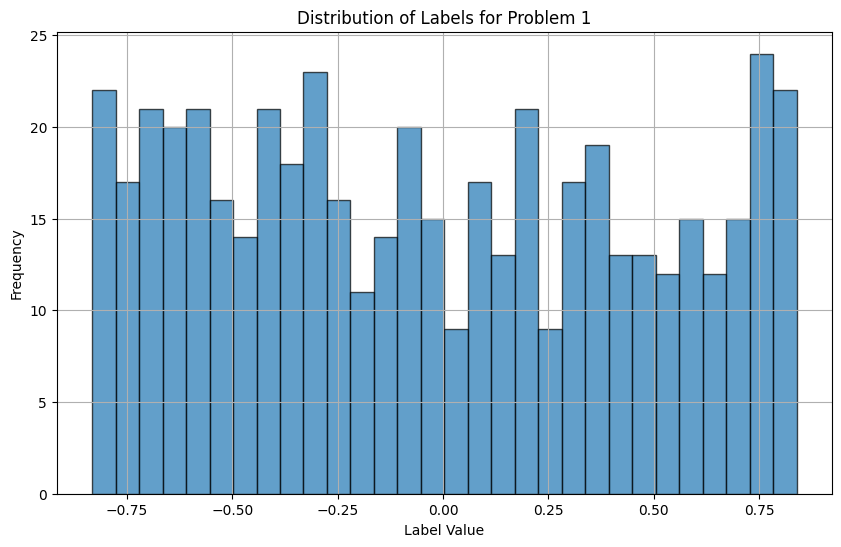

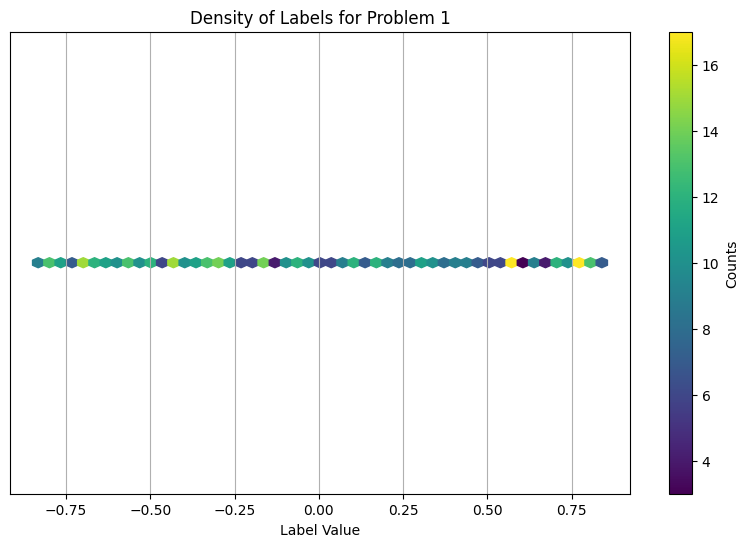

Problem number:  2
Input shape: (3, 5000)  Example of sample:  [ 4.52991777 -0.18656382 -1.60071107]
Labels shape: (5000,)  Example of label:  7410414.436905311
terminal_list:  ['x0', 'x1', 'x2']
input shape is  (3, 5000)
vars shape is  (5000,)


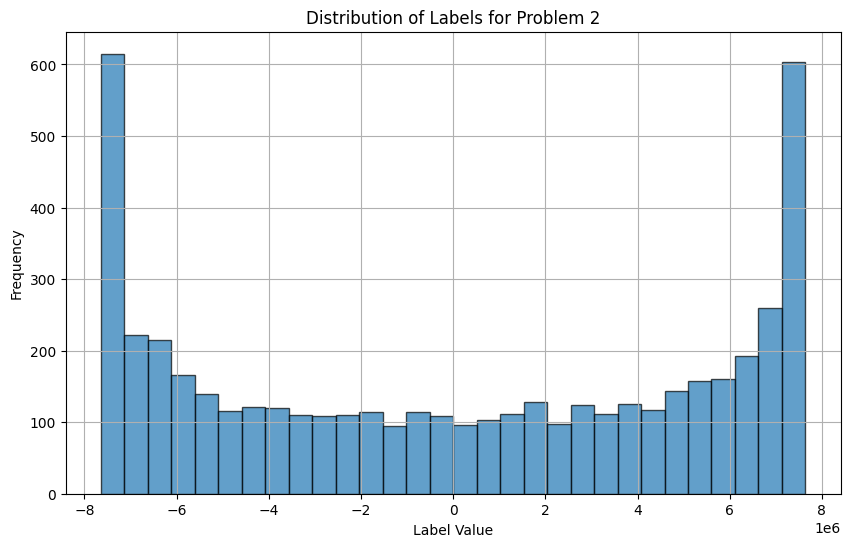

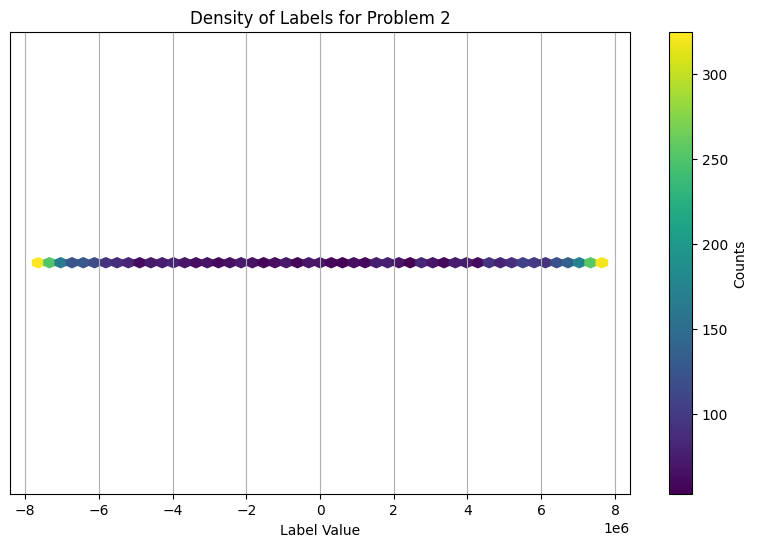

Problem number:  3
Input shape: (3, 5000)  Example of sample:  [ 1.52827812 -2.67876092 -3.73351453]
Labels shape: (5000,)  Example of label:  40.96071445158248
terminal_list:  ['x0', 'x1', 'x2']
input shape is  (3, 5000)
vars shape is  (5000,)


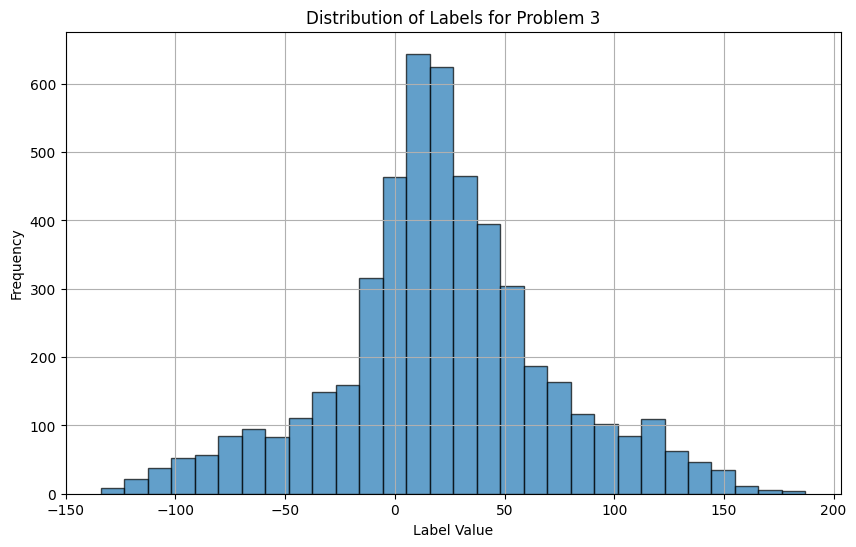

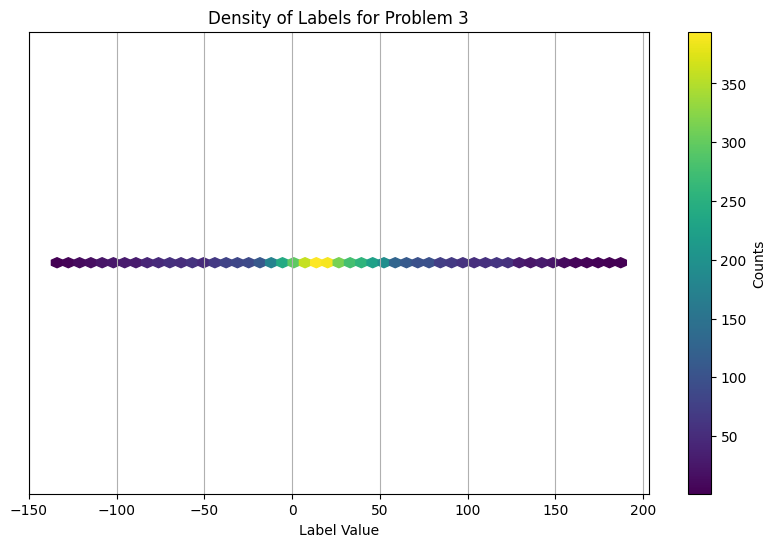

Problem number:  4
Input shape: (2, 5000)  Example of sample:  [ 3.15087424 -1.73013313]
Labels shape: (5000,)  Example of label:  1.8823292724754674
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


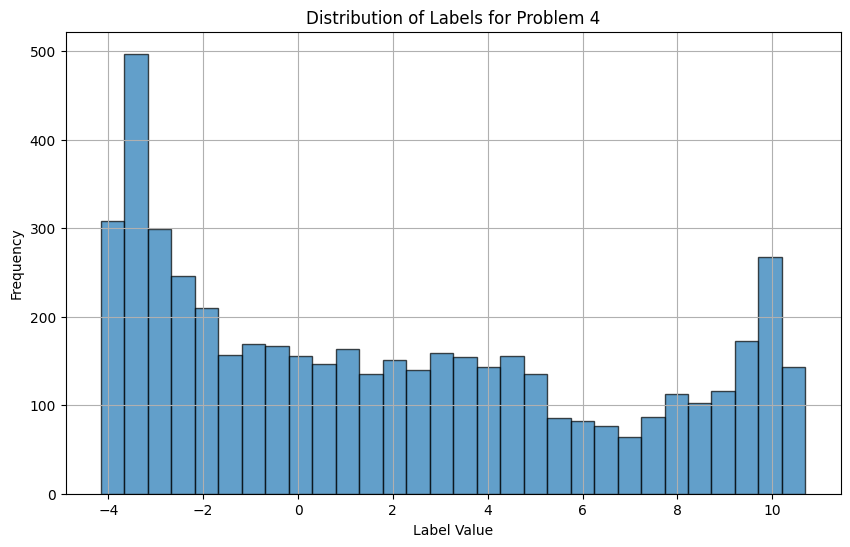

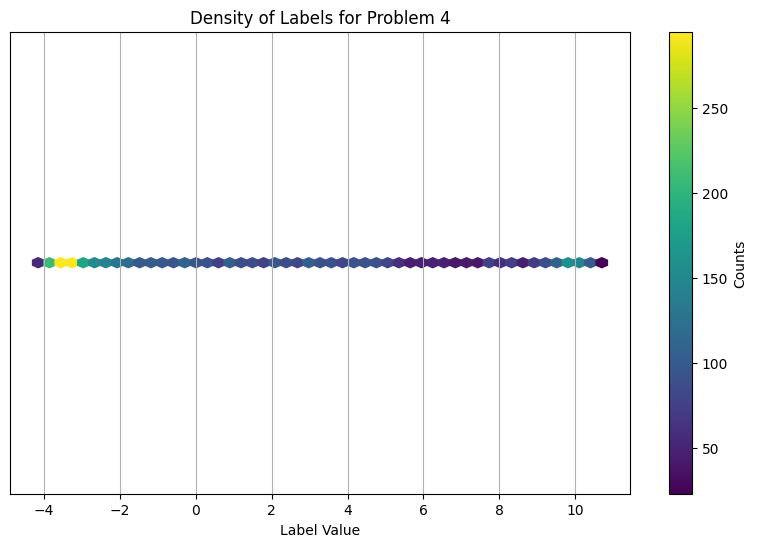

Problem number:  5
Input shape: (2, 5000)  Example of sample:  [0.47539734 4.04724856]
Labels shape: (5000,)  Example of label:  1.6192929113321065e-10
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


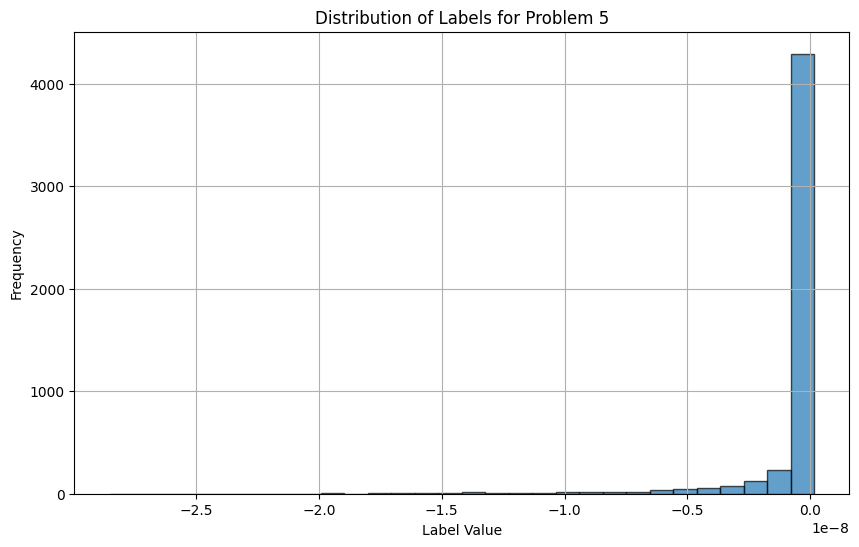

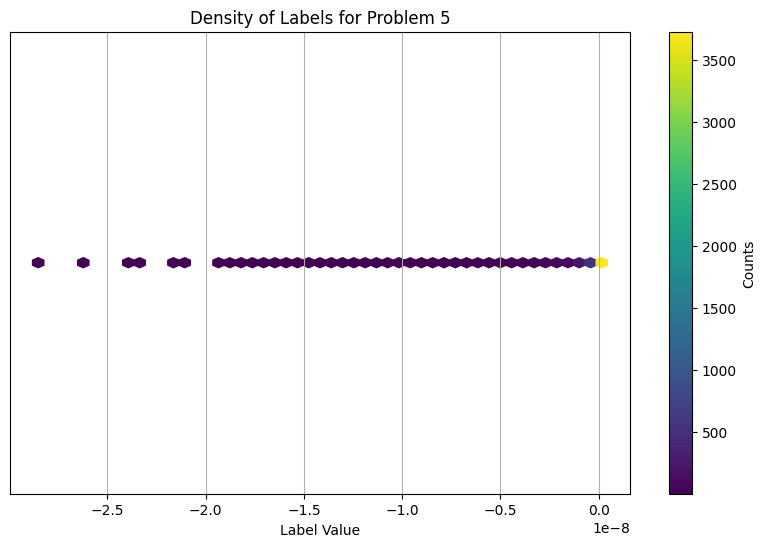

Problem number:  6
Input shape: (2, 5000)  Example of sample:  [ 1.00178758 -1.98101753]
Labels shape: (5000,)  Example of label:  -4.052636527634054
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


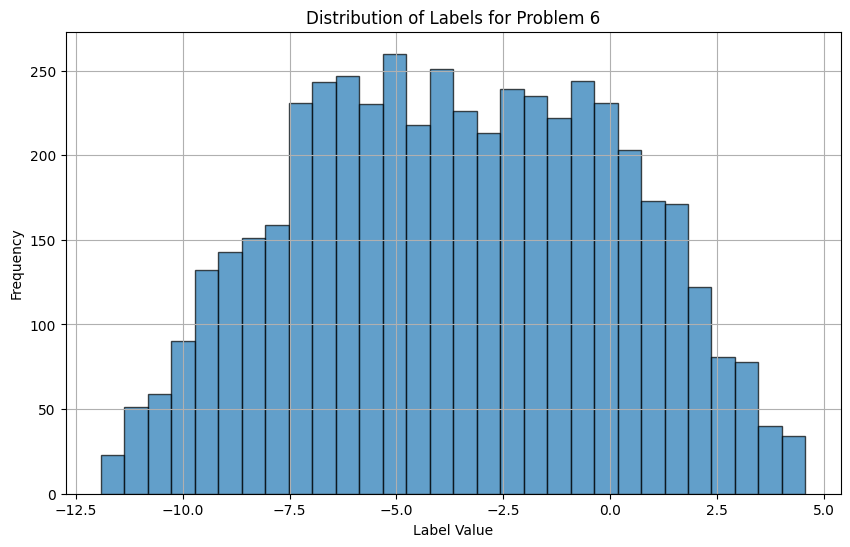

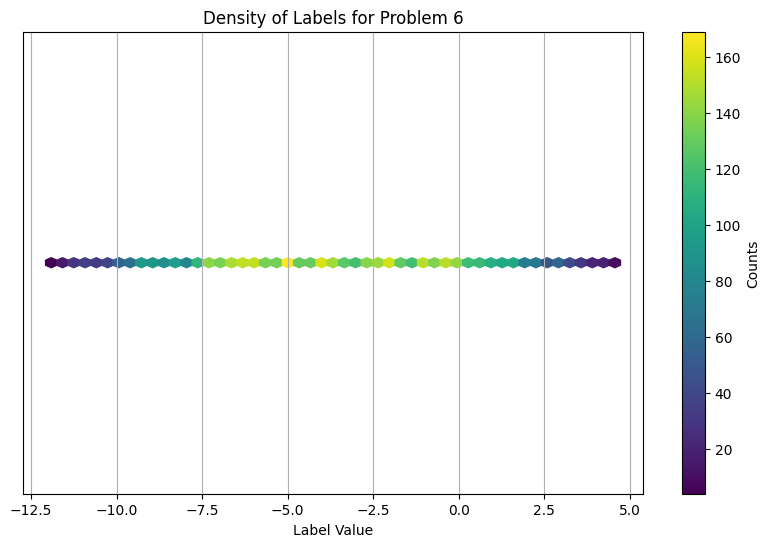

Problem number:  7
Input shape: (2, 5000)  Example of sample:  [0.19267392 1.98111504]
Labels shape: (5000,)  Example of label:  4.886874543831234
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


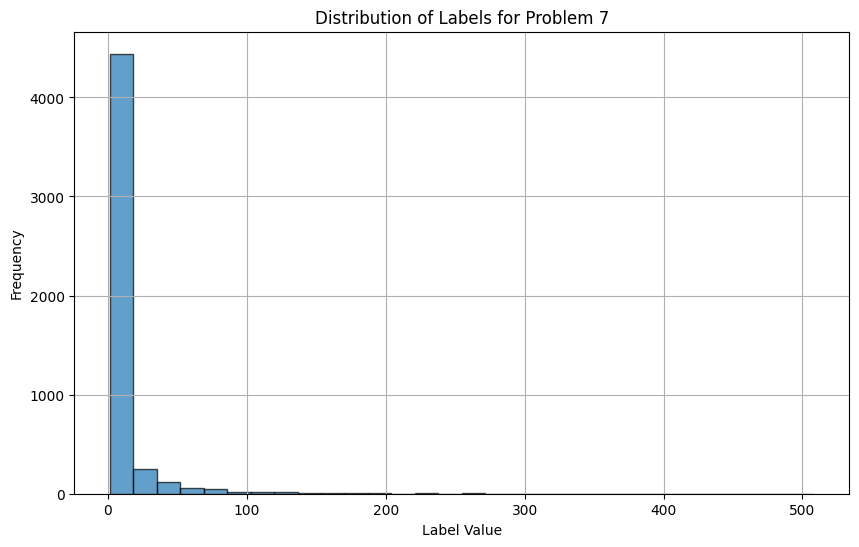

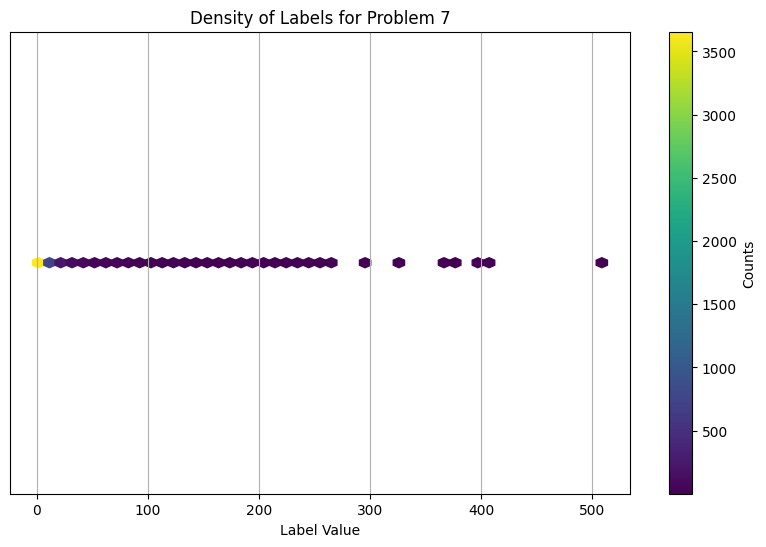

Problem number:  8
Input shape: (6, 50000)  Example of sample:  [-3.0855975  -3.93221086 -3.47850254  4.3036516   3.71133209 -3.5473932 ]
Labels shape: (50000,)  Example of label:  -3362.5447994306087
terminal_list:  ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
input shape is  (6, 50000)
vars shape is  (50000,)


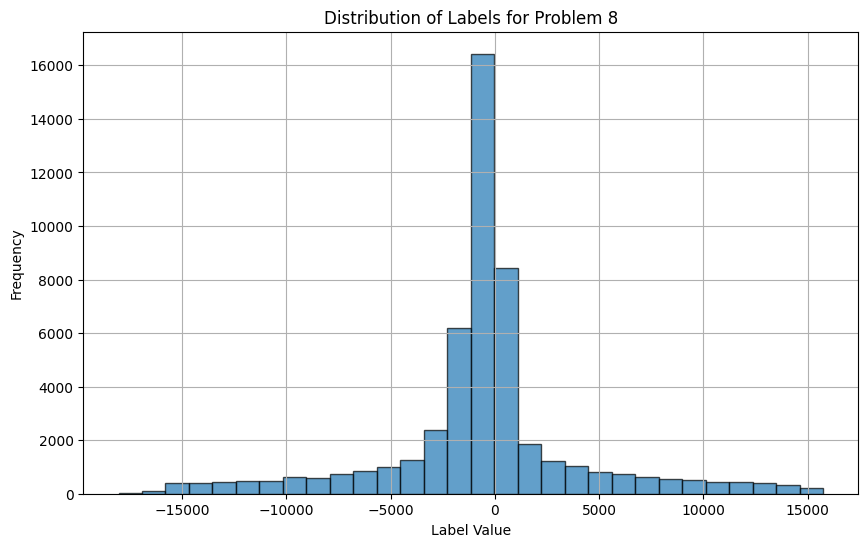

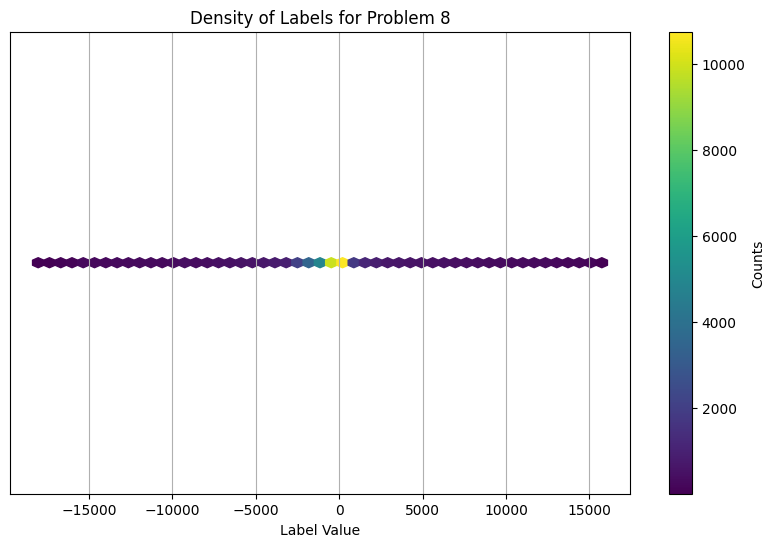

In [ ]:
from gxgp import Node
import numpy as np
import matplotlib.pyplot as plt

problem_numbers = [1, 2, 3, 4, 5, 6, 7, 8]
for problem_number in problem_numbers:
    print("=====================================")
    print("Problem number: ", problem_number)

    problem = np.load(f'./data/problem_{problem_number}.npz')
    input = problem['x']
    labels = problem['y']

    print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
    print("Labels shape:", labels.shape, " Example of label: ", labels[0])

    # Terminal set
    terminal_list = ['x' + str(i) for i in range(input.shape[0])]

    print("terminal_list: ", terminal_list)

    print("input shape is ", input.shape)

    vars = []
    for j in range(input.shape[1]):
        cur_vars = {'x'+str(i): input[i][j] for i in range(input.shape[0])}
        # print("cur_vars is ", cur_vars)
        vars.append(cur_vars)
    vars = np.array(vars)

    print("vars shape is ", vars.shape)

    # Plot the distribution of the labels as a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Labels for Problem {problem_number}')
    plt.xlabel('Label Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot the distribution of the labels as a hexbin plot
    plt.figure(figsize=(10, 6))
    plt.hexbin(labels, np.zeros_like(labels), gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Counts')
    plt.title(f'Density of Labels for Problem {problem_number}')
    plt.xlabel('Label Value')
    plt.yticks([])  # Hide y-axis ticks
    plt.grid(True)
    plt.show()

### Test the training loop's reuse

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import math

### SETTINGS ###
USE_JOBLIB_INSTEAD_OF_THREADPOOL = True # I modified fitness computation only, but the others would benefit too IMO if you want to try

ALREADY_INITIALIZED = False
if ALREADY_INITIALIZED:
    START_FROM_GENERATION = 100
    END_AT_GENERATION = 150
else:
    START_FROM_GENERATION = 0
### END SETTINGS ###


# Parameters
# crossover = recombination_crossover
OFFSPRING_SIZE = 200
POPULATION_SIZE = 100
OUTSIDER_SIZE = math.ceil(OFFSPRING_SIZE*0.1)
INITIAL_PM = 0.2
FINAL_PM = 0.05                                          # CHANGE:: before we had 0.05 here
x_elitism = 0.08
MAX_GENERATIONS = 100
HEIGHT = 5
PC = 0.15                                           # CHANGE:: before we had 0.1 here
P_PICK_CONSTANT = 0.4
P_CUT_TREE = 0.05
CONSTANTS = crammed_constants

if ALREADY_INITIALIZED:
    MAX_GENERATIONS = END_AT_GENERATION

conf = {
    "problem": problem_number,
    # "crossover": crossover,
    "OFFSPRING_SIZE": OFFSPRING_SIZE,
    "POPULATION_SIZE": POPULATION_SIZE,
    "OUTSIDER_SIZE": OUTSIDER_SIZE,
    "INITIAL_PM": INITIAL_PM,
    "FINAL_PM": FINAL_PM,
    "x_elitism": x_elitism,
    "MAX_GENERATIONS": MAX_GENERATIONS,
    "HEIGHT": HEIGHT,
    "PC": PC,
    "P_PICK_CONSTANT": P_PICK_CONSTANT,
    "P_CUT_TREE": P_CUT_TREE,
    "CONSTANTS": CONSTANTS,
}

for generation in range(START_FROM_GENERATION, MAX_GENERATIONS):
    print(f"Generation {generation}")

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49
Generation 50
Generation 51
Generation 52
Generation 53
Generation 54
Generation 55
Generation 56
Generation 57
Generation 58
Generation 59
Generation 60
Generation 61
Generation 62
Generation 63
Generation 64
Generation 65
Generation 66
Generation 67
Generation 68
Generation 69
Generation 70
Generation 71
Ge

### Testing problem 5

In [37]:
import numpy as np
from gxgp import Node

problem_number = 5
problem = np.load(f'./data/problem_{problem_number}.npz')
input = problem['x']
labels = problem['y']

print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
print("Labels shape:", labels.shape, " Example of label: ", labels[0])

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print("terminal_list: ", terminal_list)

print("input shape is ", input.shape)

vars = []
for j in range(input.shape[1]):
    cur_vars = {'x'+str(i): input[i][j] for i in range(input.shape[0])}
    # print("cur_vars is ", cur_vars)
    vars.append(cur_vars)
vars = np.array(vars)

print("vars shape is ", vars.shape)



print("input is:")
print(input)

def my_sqrt(x: np.ndarray) -> np.ndarray:
    return np.sqrt(np.abs(x))

def my_log(x: np.ndarray) -> np.ndarray:
    return np.log(np.abs(x))

def my_reciprocal(x: np.ndarray) -> np.ndarray:
    if not isinstance(x, np.ndarray):
        if x == 0:
            return 0
        else:
            return np.reciprocal(x)
        
    out = []
    for el in x:
        if el == 0:
            out.append(el)
        else:
            out.append(np.reciprocal(el))
    return np.array(out)

def f4(x: np.ndarray) -> np.ndarray:
    return np.divide(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.subtract(np.add(x[1], 96), np.exp(np.add(x[1], x[0]))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.add(x[1], x[0]))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.abs(np.abs(np.add(x[1], x[0]))))), np.exp(np.abs(np.add(x[1], x[0])))), np.exp(np.power(30, np.power(np.exp(np.abs(np.add(x[1], np.exp(x[0])))), np.subtract(x[0], x[0])))))# Resulting fitness

# print(f"MSE (train): {100*np.square(labels-f4(input)).sum()/len(labels):g}")

my_output = f4(input)
my_output = [(float(out)) for out in my_output]
print("my - gt")
for my, gt in zip(my_output, labels):
    print(f"{my} - {gt}")

Input shape: (2, 5000)  Example of sample:  [0.47539734 4.04724856]
Labels shape: (5000,)  Example of label:  1.6192929113321065e-10
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)
input is:
[[0.47539734 1.20759887 1.98521883 ... 0.10755488 2.66372664 0.53016746]
 [4.04724856 2.88064329 0.93691996 ... 4.17775468 1.08064172 0.49246628]]
my - gt
-8.541832188768091e-11 - 1.6192929113321065e-10
-5.2131695614899935e-11 - 1.4520413679161038e-10
-1.005513302689568e-11 - 1.434106560021669e-10
-3.819681502827777e-10 - 8.438257658578308e-12
-3.6258159105789e-10 - 4.973203035807006e-11
-8.341578824383628e-11 - 1.5447407236301468e-10
-6.460450474660298e-11 - 1.3225607074597504e-10
2.539265957524706e-12 - 1.5110984141958942e-10
-2.764356332294444e-10 - 1.2516423365975744e-10
-6.531956491567494e-10 - -2.506011250514312e-11
-1.067532064114728e-08 - -9.32601635869375e-09
-5.952965347405369e-10 - 7.537176966609226e-11
-1.8174814477467803e-09 - -1.0462997876612143e-09
-1.69